# Introduction to Graph Convolutional Networks

In [89]:
from torch_geometric.datasets import Planetoid, FacebookPagePage
import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch_geometric.utils import degree
from collections import Counter
import matplotlib.pyplot as plt
from torch_geometric.datasets import WikipediaNetwork
import torch_geometric.transforms as T
import pandas as pd
import numpy as np
import seaborn as sns
import pandas as pd
from io import BytesIO
from urllib.request import urlopen
from zipfile import ZipFile

In [10]:
def get_dataset(name):
    if name == 'FacebookPagePage':
        dataset = FacebookPagePage(root='../data/FacebookPagePage')
        print(f'Dataset: {dataset}')
    elif name == 'Cora':
         dataset = Planetoid(root='../data/Cora', name='Cora')
         print(f'Dataset: {dataset.name}')
    data = dataset[0]
    
    print(f'Number of graphs: {len(dataset)}')
    print(f'Number of Nodes: {data.x.shape[0]}')
    print('Number of features: ', dataset.num_features)
    print('Number of classes: ', dataset.num_classes)
    print('----------------')
    print('Graph:')
    print(f'Are edges directed: {data.is_directed()}')
    print(f'Graph Has Isolated Nodes: {data.has_isolated_nodes()}')
    print(f'Graph has loops: {data.has_self_loops()}')
    
    return dataset
cora_dataset = get_dataset('Cora')
print('----------------')
print('----------------')
fb_dataset = get_dataset('FacebookPagePage')

Dataset: Cora
Number of graphs: 1
Number of Nodes: 2708
Number of features:  1433
Number of classes:  7
----------------
Graph:
Are edges directed: False
Graph Has Isolated Nodes: False
Graph has loops: False
----------------
----------------
Dataset: FacebookPagePage()
Number of graphs: 1
Number of Nodes: 22470
Number of features:  128
Number of classes:  4
----------------
Graph:
Are edges directed: False
Graph Has Isolated Nodes: False
Graph has loops: True


Text(0, 0.5, 'Number of Nodes')

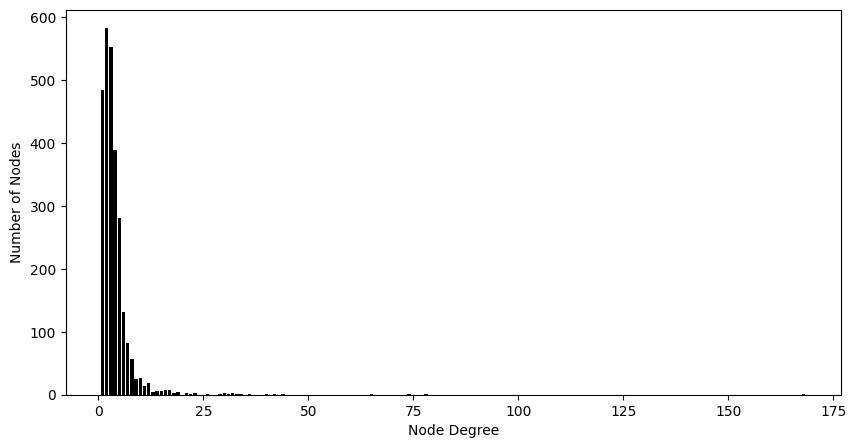

In [17]:
degrees = degree(cora_dataset[0].edge_index[0]).numpy()
numbers = Counter(degrees) # Count the number of nodes with each degree
plt.figure(figsize=(10, 5))
plt.bar(numbers.keys(), numbers.values(), color='k')
plt.xlabel('Node Degree')
plt.ylabel('Number of Nodes')

Text(0, 0.5, 'Number of Nodes')

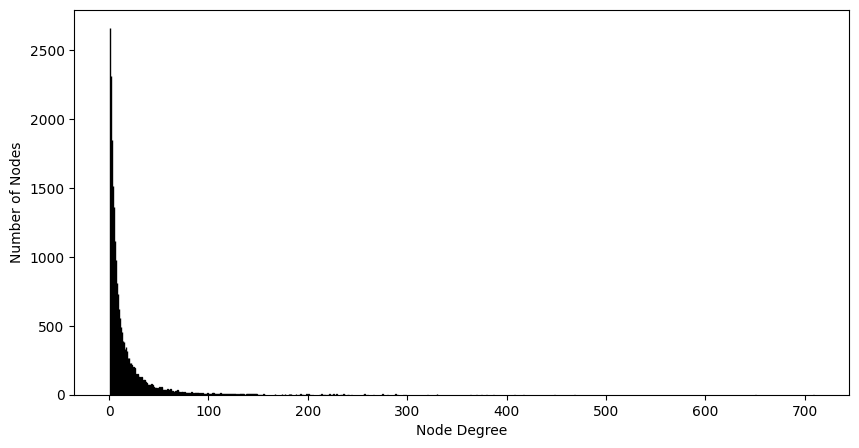

In [14]:
degrees = degree(fb_dataset[0].edge_index[0]).numpy()
numbers = Counter(degrees)
plt.figure(figsize=(10, 5))
plt.bar(numbers.keys(), numbers.values(), edgecolor='k')
plt.xlabel('Node Degree')
plt.ylabel('Number of Nodes')

In [28]:
class GCN(torch.nn.Module):
    def __init__(self, dim_in,dim_h, dim_out):
        super().__init__()
        self.gcn1 = GCNConv(dim_in, dim_h) # First layer
        self.gcn2 = GCNConv(dim_h, dim_out) # Second layer
    def accuracy(self, y_pred, y_true):

        acc = torch.sum(y_pred == y_true) / len(y_true)
        return acc
    def forward(self, x, edge_index):
        h = self.gcn1(x, edge_index)
        h = F.relu(h)
        h = self.gcn2(h, edge_index)
        return F.log_softmax(h, dim=1)
    def fit(self, data, epochs=200):
        criterion = torch.nn.CrossEntropyLoss()
        optimizer = torch.optim.Adam(self.parameters(), lr=0.01, weight_decay=5e-4)
        self.train()
        for epoch in range(epochs+1):
            optimizer.zero_grad()
            out = self(data.x, data.edge_index)
            loss = criterion(out[data.train_mask], data.y[data.train_mask])
            acc = self.accuracy(out[data.train_mask].argmax(dim=1), data.y[data.train_mask])
            loss.backward()
            optimizer.step()
            if epoch % 20 == 0:
                val_loss = criterion(out[data.val_mask], data.y[data.val_mask])
                val_acc = self.accuracy(out[data.val_mask].argmax(dim=1), data.y[data.val_mask])
                print(f'Epoch {epoch:>3}, Loss: {loss:.3f},Train Accuracy {acc*100:.2f} , Val Loss: {val_loss:.2f}, Val Acc: {val_acc*100:.2f}%')
    @torch.no_grad()
    def test(self, data):
        self.eval()
        out = self(data.x, data.edge_index)
        pred = out.argmax(dim=1)
        test_acc = self.accuracy(pred[data.test_mask], data.y[data.test_mask])
        return test_acc

In [30]:

gcn = GCN(cora_dataset.num_features, 16, cora_dataset.num_classes)
print(gcn)
gcn.fit(cora_dataset[0], epochs=100)
acc = gcn.test(cora_dataset[0])
print(f'\nGCN test accuracy on Cora Dataset: {acc*100:.2f}%\n')

GCN(
  (gcn1): GCNConv(1433, 16)
  (gcn2): GCNConv(16, 7)
)
Epoch   0, Loss: 1.938,Train Accuracy 20.00 , Val Loss: 1.95, Val Acc: 17.40%
Epoch  20, Loss: 0.109,Train Accuracy 100.00 , Val Loss: 0.81, Val Acc: 76.40%
Epoch  40, Loss: 0.015,Train Accuracy 100.00 , Val Loss: 0.82, Val Acc: 75.20%
Epoch  60, Loss: 0.015,Train Accuracy 100.00 , Val Loss: 0.78, Val Acc: 76.00%
Epoch  80, Loss: 0.017,Train Accuracy 100.00 , Val Loss: 0.77, Val Acc: 76.20%
Epoch 100, Loss: 0.016,Train Accuracy 100.00 , Val Loss: 0.76, Val Acc: 75.60%

GCN test accuracy on Cora Dataset: 79.40%



In [32]:
fb_data = fb_dataset[0]
fb_data.train_mask = range(18000)
fb_data.val_mask = range(18001, 20000)
fb_data.test_mask = range(20001, 22470)
gcn = GCN(fb_dataset.num_features, 16, fb_dataset.num_classes)
print(gcn)
gcn.fit(fb_data, epochs=100)
acc = gcn.test(fb_data)
print(f'\nGCN test accuracy on FB Page-Page Dataset: {acc*100:.2f}%\n')

GCN(
  (gcn1): GCNConv(128, 16)
  (gcn2): GCNConv(16, 4)
)
Epoch   0, Loss: 1.581,Train Accuracy 27.32 , Val Loss: 1.59, Val Acc: 26.06%
Epoch  20, Loss: 0.468,Train Accuracy 84.55 , Val Loss: 0.46, Val Acc: 84.99%
Epoch  40, Loss: 0.327,Train Accuracy 89.23 , Val Loss: 0.32, Val Acc: 88.84%
Epoch  60, Loss: 0.283,Train Accuracy 91.11 , Val Loss: 0.28, Val Acc: 90.30%
Epoch  80, Loss: 0.260,Train Accuracy 92.19 , Val Loss: 0.26, Val Acc: 91.60%
Epoch 100, Loss: 0.244,Train Accuracy 92.82 , Val Loss: 0.25, Val Acc: 92.70%

GCN test accuracy on FB Page-Page Dataset: 91.49%



## Predicting Web Traffic with Node Regression

In [90]:


wiki_dataset = WikipediaNetwork(root='../data/WikipediaNetwork', name='chameleon', transform=T.RandomNodeSplit(num_val=200, num_test=500))
wiki_data = wiki_dataset[0]
print(f'Dataset: {dataset}')
print(f'Number of graphs: {len(dataset)}')
print(f'Number of Nodes: {wiki_data.x.shape[0]}')
print('Number of features: ', dataset.num_features)
print('Number of classes: ', dataset.num_classes)
print('----------------')
print('Graph:')
print(f'Are edges directed: {wiki_data.is_directed()}')
print(f'Graph Has Isolated Nodes: {wiki_data.has_isolated_nodes()}')
print(f'Graph has loops: {wiki_data.has_self_loops()}')

Dataset: WikipediaNetwork()
Number of graphs: 1
Number of Nodes: 2277
Number of features:  2325
Number of classes:  5
----------------
Graph:
Are edges directed: True
Graph Has Isolated Nodes: False
Graph has loops: True


In [ ]:
url = 'https://snap.stanford.edu/data/wikipedia.zip'
with urlopen(url) as zurl:
    with ZipFile(BytesIO(zurl.read())) as zfile:
        zfile.extractall('../data/WikipediaNetwork/')


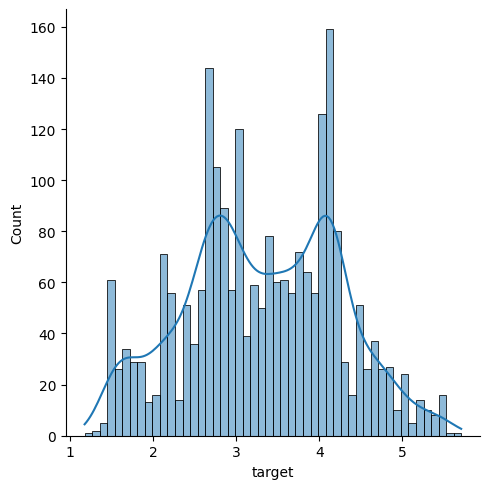

In [91]:
df = pd.read_csv('../data/WikipediaNetwork/wikipedia/chameleon/musae_chameleon_target.csv')
df['target'] = np.log10(df['target'])
wiki_data.y = torch.tensor(df['target'].values, dtype=torch.float)
sns.displot(df['target'], bins=50, kde=True)

In [92]:
class GCN_Regression(torch.nn.Module):
    def __init__(self, dim_in, dim_h, dim_out):
        super().__init__()
        self.gcn1 = GCNConv(dim_in, dim_h*4) # First layer
        self.gcn2 = GCNConv(dim_h*4, dim_h*2) # Second layer
        self.gcn3 = GCNConv(dim_h*2, dim_h) # Third layer
        self.linear = torch.nn.Linear(dim_h, dim_out) # Final Linear layer
    def forward(self, x, edge_index):
        h = self.gcn1(x, edge_index)
        h = torch.relu(h)
        h = F.dropout(h, p=0.5, training=self.training)
        h = self.gcn2(h, edge_index)
        h = torch.relu(h)
        h = F.dropout(h, p=0.5, training=self.training)
        h = self.gcn3(h, edge_index)
        h = torch.relu(h)
        h = self.linear(h)
        return h
    def fit(self, data, epochs=200):
        
        optimizer = torch.optim.Adam(self.parameters(), lr=0.02, weight_decay=5e-4)
        self.train()
        for epoch in range(epochs+1):
            optimizer.zero_grad()
            out = self(data.x, data.edge_index)
            loss = F.mse_loss(out.squeeze()[data.train_mask], data.y[data.train_mask].float())
            loss.backward()
            optimizer.step()
            if epoch % 20 == 0:
                val_loss = F.mse_loss(out.squeeze()[data.val_mask], data.y[data.val_mask].float())
                print(f'Epoch {epoch:>3}, Loss: {loss:.3f}, Val Loss: {val_loss:.2f}')
    @torch.no_grad()
    def test(self, data):
        self.eval()
        out = self(data.x, data.edge_index)
        pred = out.squeeze()[data.test_mask]
        test_loss = F.mse_loss(pred, data.y[data.test_mask].float())
        return test_loss

In [94]:

# Check if CUDA is available
print(f"CUDA available: {torch.cuda.is_available()}")

# Get the number of available GPUs
num_gpus = torch.cuda.device_count()
print(f"Number of GPUs available: {num_gpus}")

# List all GPU names
for i in range(num_gpus):
    print(f"GPU {i}: {torch.cuda.get_device_name(i)}")
# Get the current device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

CUDA available: True
Number of GPUs available: 2
GPU 0: NVIDIA GeForce RTX 3090
GPU 1: NVIDIA GeForce RTX 3090
Using device: cuda


### Using CPU

In [96]:
gcn_reg = GCN_Regression(wiki_dataset.num_features, 128, 1)
print(gcn_reg)
gcn_reg.fit(wiki_data, epochs=200)
test_loss = gcn_reg.test(wiki_data)
rmse = np.sqrt(test_loss.item())
print(f'\nGCN test loss (MSE) on Wikipedia Dataset: {test_loss:.2f}\n')
print(f'RMSE: {rmse:.2f}\n')

GCN_Regression(
  (gcn1): GCNConv(2325, 512)
  (gcn2): GCNConv(512, 256)
  (gcn3): GCNConv(256, 128)
  (linear): Linear(in_features=128, out_features=1, bias=True)
)
Epoch   0, Loss: 11.806, Val Loss: 12.17
Epoch  20, Loss: 12.248, Val Loss: 12.63
Epoch  40, Loss: 11.424, Val Loss: 11.79
Epoch  60, Loss: 10.382, Val Loss: 10.73
Epoch  80, Loss: 9.291, Val Loss: 9.62
Epoch 100, Loss: 8.222, Val Loss: 8.53
Epoch 120, Loss: 6.986, Val Loss: 7.27
Epoch 140, Loss: 1.814, Val Loss: 1.95
Epoch 160, Loss: 1.020, Val Loss: 1.02
Epoch 180, Loss: 0.875, Val Loss: 0.93
Epoch 200, Loss: 0.858, Val Loss: 0.90

GCN test loss (MSE) on Wikipedia Dataset: 0.86

RMSE: 0.93



## Using GPU

In [97]:
gcn_reg = GCN_Regression(wiki_dataset.num_features, 128, 1).to(device)
wiki_data_gpu = wiki_data.to(device)
print(gcn_reg)
gcn_reg.fit(wiki_data_gpu, epochs=200)
test_loss = gcn_reg.test(wiki_data_gpu)
rmse = np.sqrt(test_loss.item())
print(f'\nGCN test loss (MSE) on Wikipedia Dataset: {test_loss:.2f}\n')
print(f'RMSE: {rmse:.2f}\n')

GCN_Regression(
  (gcn1): GCNConv(2325, 512)
  (gcn2): GCNConv(512, 256)
  (gcn3): GCNConv(256, 128)
  (linear): Linear(in_features=128, out_features=1, bias=True)
)
Epoch   0, Loss: 11.361, Val Loss: 11.75
Epoch  20, Loss: 11.453, Val Loss: 11.82
Epoch  40, Loss: 8.430, Val Loss: 8.27
Epoch  60, Loss: 1.541, Val Loss: 1.71
Epoch  80, Loss: 0.687, Val Loss: 0.72
Epoch 100, Loss: 0.611, Val Loss: 0.73
Epoch 120, Loss: 0.460, Val Loss: 0.58
Epoch 140, Loss: 0.421, Val Loss: 0.64
Epoch 160, Loss: 0.364, Val Loss: 0.68
Epoch 180, Loss: 0.327, Val Loss: 0.54
Epoch 200, Loss: 0.320, Val Loss: 0.62

GCN test loss (MSE) on Wikipedia Dataset: 0.63

RMSE: 0.80



<Axes: >

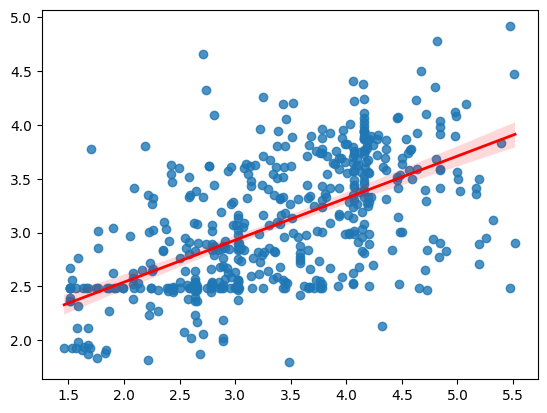

In [101]:
outp = gcn_reg(wiki_data.x, wiki_data.edge_index)
pred = outp.squeeze()[wiki_data.test_mask].cpu().detach().numpy()
# outp.squeeze()[wiki_data.test_mask]. detach().numpy()

sns.regplot(y=pred, x=wiki_data.y[wiki_data.test_mask].cpu().numpy(), line_kws={'color': 'red', 'lw': 2})


In [105]:
from torch_geometric.utils import to_dense_adj
class VanillaGNNLayer(torch.nn.Module):
    def __init__(self, dim_in, dim_out):
        super().__init__()
        self.linear = torch.nn.Linear(dim_in, dim_out, bias=False)
    def forward(self, x, adjacency):
        x = self.linear(x)
        x = torch.sparse.mm(adjacency, x)
        return x
    
class VanillaGNN(torch.nn.Module):
    def __init__(self, dim_in, dim_h, dim_out):
        super().__init__()
        self.gnn1 = VanillaGNNLayer(dim_in, dim_h*4) # First layer
        self.gnn2 = VanillaGNNLayer(dim_h*4, dim_h*2)
        self.gnn3 = VanillaGNNLayer(dim_h*2, dim_h)
        self.linear = torch.nn.Linear(dim_h, dim_out)
    
    def forward(self, x, adjacency):
        h = self.gnn1(x, adjacency)
        h = torch.relu(h)
        h = F.dropout(h, p=0.5, training=self.training)
        h = self.gnn2(h, adjacency)
        h = torch.relu(h)
        h = F.dropout(h, p=0.5, training=self.training)
        h = self.gnn3(h, adjacency)
        h = torch.relu(h)
        h = self.linear(h)
        return h
    def fit(self, data, epochs=200):
        optimizer = torch.optim.Adam(self.parameters(), lr=0.02, weight_decay=5e-4)
        self.train()
        for epoch in range(epochs+1):
            optimizer.zero_grad()
            out = self(data.x, adjacency)
            loss = F.mse_loss(out.squeeze()[data.train_mask], data.y[data.train_mask].float())
            loss.backward()
            optimizer.step()
            if epoch % 20 == 0:
                val_loss = F.mse_loss(out.squeeze()[data.val_mask], data.y[data.val_mask].float())
                print(f'Epoch {epoch:>3}, Loss: {loss:.3f}, Val Loss: {val_loss:.2f}')
    @torch.no_grad()
    def test(self, data):
        self.eval()
        out = self(data.x, adjacency)
        pred = out.squeeze()[data.test_mask]
        test_loss = F.mse_loss(pred, data.y[data.test_mask].float())
        return test_loss
gnn_vanilla = VanillaGNN(wiki_dataset.num_features, 128, 1).to(device)
wiki_data_gpu = wiki_data.to(device)

adjacency = to_dense_adj(wiki_data_gpu.edge_index.to(device))[0]
adjacency += torch.eye(len(adjacency), device=device)
print(gnn_vanilla)
gnn_vanilla.fit(wiki_data_gpu, epochs=200)
test_loss = gnn_vanilla.test(wiki_data_gpu)
rmse = np.sqrt(test_loss.item())
print(f'\nVanilla GNN test loss (MSE) on Wikipedia Dataset: {test_loss:.2f}\n')
print(f'RMSE: {rmse:.2f}\n')

VanillaGNN(
  (gnn1): VanillaGNNLayer(
    (linear): Linear(in_features=2325, out_features=512, bias=False)
  )
  (gnn2): VanillaGNNLayer(
    (linear): Linear(in_features=512, out_features=256, bias=False)
  )
  (gnn3): VanillaGNNLayer(
    (linear): Linear(in_features=256, out_features=128, bias=False)
  )
  (linear): Linear(in_features=128, out_features=1, bias=True)
)
Epoch   0, Loss: 4586.540, Val Loss: 7051.39
Epoch  20, Loss: 11.076, Val Loss: 11.26
Epoch  40, Loss: 10.620, Val Loss: 10.81
Epoch  60, Loss: 8.546, Val Loss: 8.77
Epoch  80, Loss: 8.009, Val Loss: 8.32
Epoch 100, Loss: 7.988, Val Loss: 8.21
Epoch 120, Loss: 10.207, Val Loss: 10.39
Epoch 140, Loss: 7.896, Val Loss: 8.11
Epoch 160, Loss: 11.122, Val Loss: 11.36
Epoch 180, Loss: 8.357, Val Loss: 8.69
Epoch 200, Loss: 8.641, Val Loss: 8.83

Vanilla GNN test loss (MSE) on Wikipedia Dataset: 8.70

RMSE: 2.95

